# IMPORTING NECESSEARY LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, train_test_split


In [2]:
df= pd.read_excel("/Users/hanishka_kela/Documents/Healthcare_Premium_Prediction_(Regression)/Data_resources/premiums_rest.xlsx")
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [3]:
df.shape

(29904, 13)

# DATA CLEANING


In [4]:
df.columns=df.columns.str.replace(' ','_').str.lower()

In [5]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [6]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

# HANDLE NA VALUES

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

# CHECKING FOR DUPLICATES

In [9]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29886.000000,29886.000000,29886.000000,29886.000000
mean,43.396105,2.379910,23.364184,20892.303821
std,13.412657,1.431201,24.740339,6936.813440
min,26.000000,-3.000000,1.000000,3625.000000
25%,34.000000,1.000000,7.000000,15697.250000
50%,42.000000,3.000000,17.000000,20489.000000
75%,52.000000,3.000000,32.000000,26360.000000
max,356.000000,5.000000,930.000000,43471.000000


In [11]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-1, -3])

In [12]:
df['number_of_dependants']=abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [13]:
numeric_coloumns = df.select_dtypes(include='number').columns
numeric_coloumns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

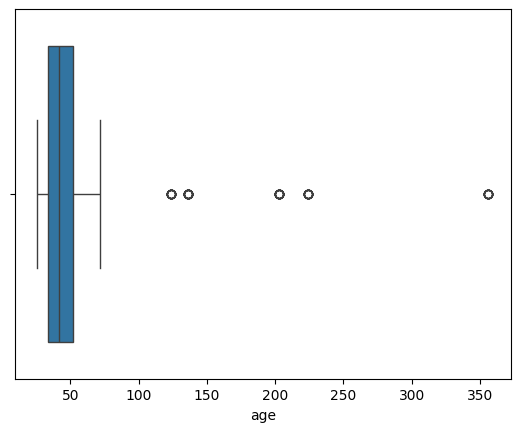

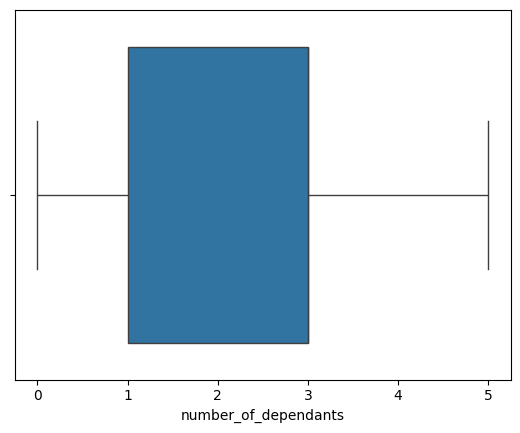

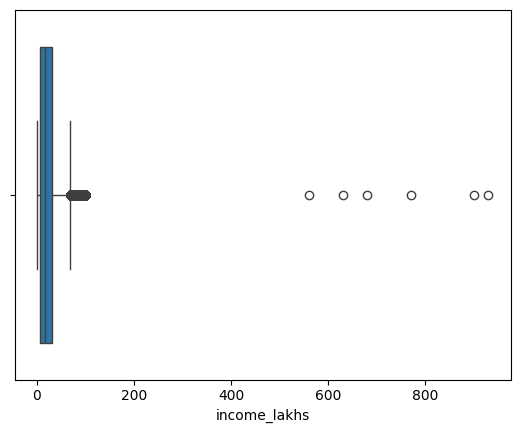

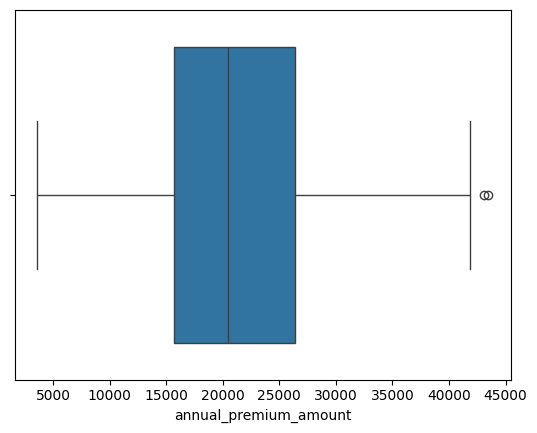

In [14]:
for col in numeric_coloumns:
    sns.boxplot(x=df[col])
    plt.show()

In [15]:
df[df.age>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [16]:
df1=df[df.age<=100].copy()
df1.describe()


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29828.000000,29828.000000,29828.000000,29828.000000
mean,43.095380,2.387790,23.371530,20901.900563
std,11.041991,1.420641,24.751262,6928.457636
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15706.000000
50%,42.000000,3.000000,17.000000,20496.000000
75%,52.000000,3.000000,32.000000,26361.000000
max,72.000000,5.000000,930.000000,43471.000000


In [17]:
def get_iqr_bounds(col):
    Q1, Q3=col.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound , upper_bound

get_iqr_bounds(df1.income_lakhs)


(-30.5, 69.5)

In [18]:
qunatile_threshold= df1.income_lakhs.quantile(0.999)
qunatile_threshold

np.float64(100.0)

In [19]:
df2 = df1[df1.income_lakhs<=qunatile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,29822.000000,29822.000000,29822.000000,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223
std,11.042430,1.420644,22.455408,6928.192115
min,26.000000,0.000000,1.000000,6538.000000
25%,34.000000,1.000000,7.000000,15705.250000
50%,42.000000,3.000000,17.000000,20495.500000
75%,52.000000,3.000000,32.000000,26360.000000
max,72.000000,5.000000,100.000000,43471.000000


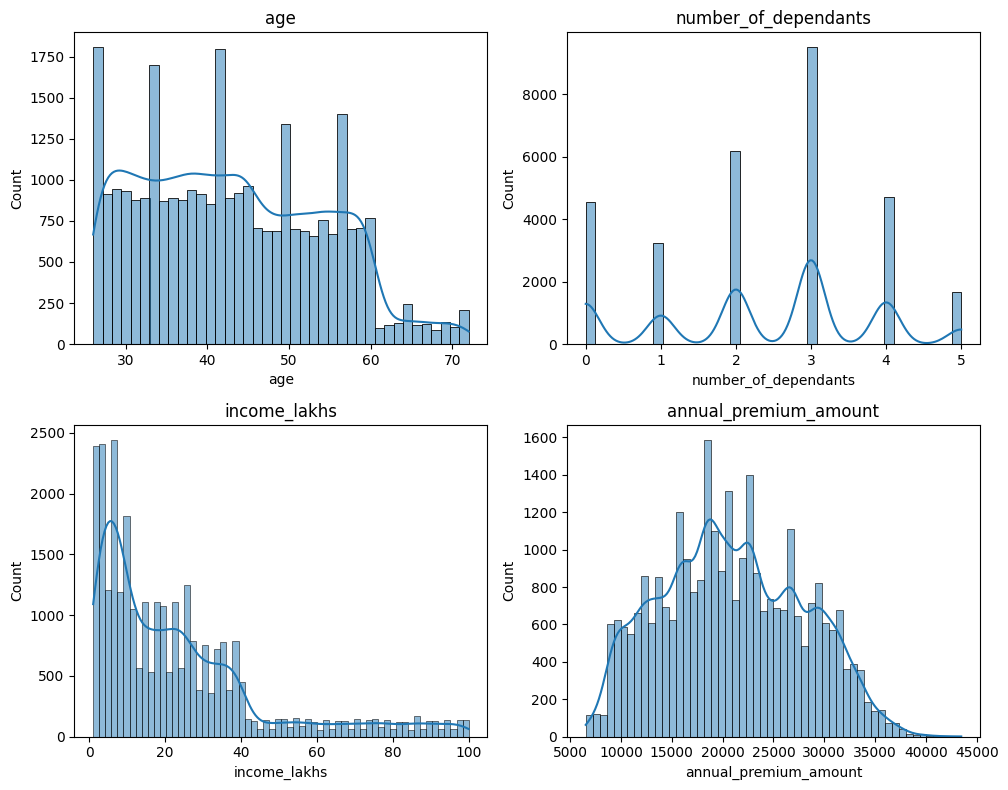

In [20]:
fig, axs=plt.subplots(nrows=2,ncols=2,figsize=(10,8))

for i,col in enumerate(numeric_coloumns):
    ax=axs[i//2,i%2]
    sns.histplot(df2[col],kde=True,ax=ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

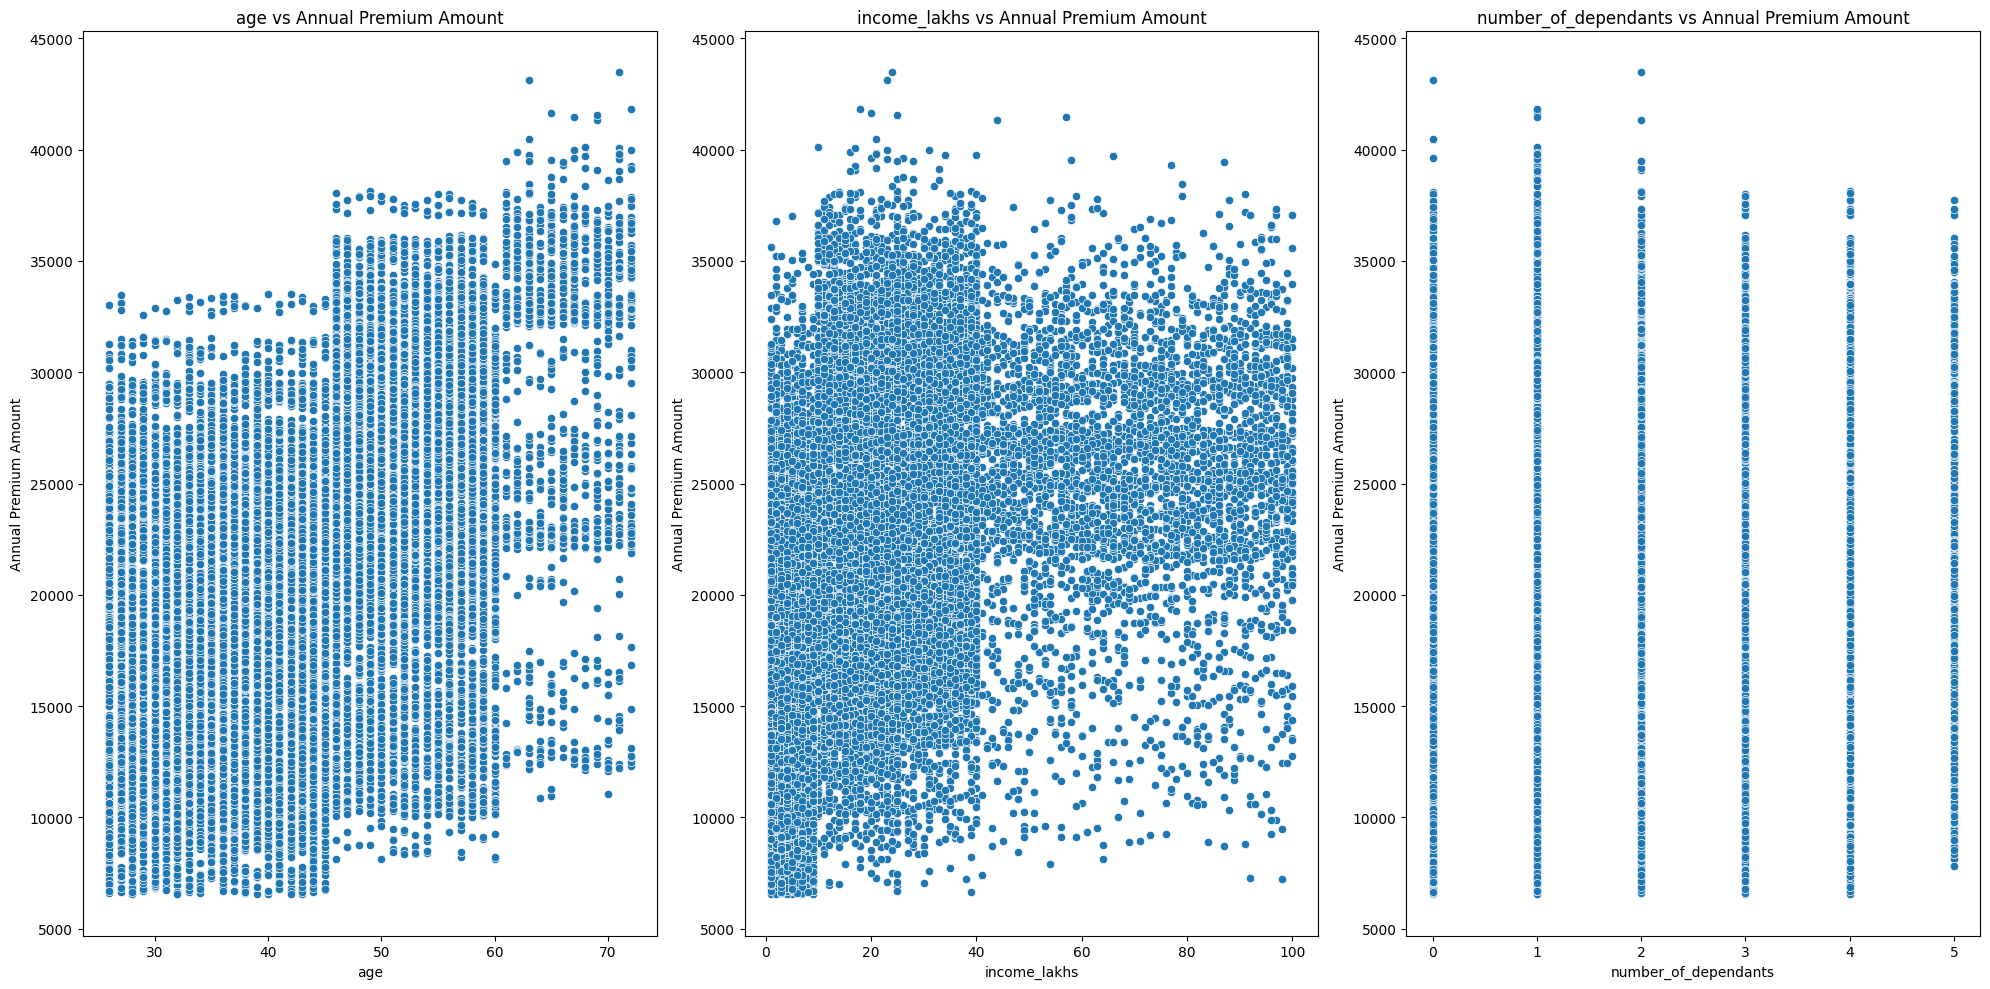

In [21]:
numeric_features=['age','income_lakhs','number_of_dependants']

fig,axes=plt.subplots(1,len(numeric_features),figsize=(20,10))
for ax, col in zip(axes, numeric_features):
    sns.scatterplot(x=df2[col],y=df2['annual_premium_amount'],ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel("Annual Premium Amount")

plt.tight_layout()
plt.show()

In [22]:
categorical_cols=df.select_dtypes(include=['object', 'category', 'bool']).columns
categorical_cols

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [23]:
for col in categorical_cols:
    print(col,' : ',df2[col].unique() )

gender  :  ['Male' 'Female']
region  :  ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status  :  ['Unmarried' 'Married']
bmi_category  :  ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status  :  ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status  :  ['Salaried' 'Self-Employed' 'Freelancer']
income_level  :  ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history  :  ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan  :  ['Bronze' 'Silver' 'Gold']


In [24]:
df2['smoking_status'].replace({
    'Smoking=0':'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking':'No Smoking'
},inplace=True)

df2['smoking_status'].unique()

/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_42745/691254365.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [25]:
pct_count=df2['gender'].value_counts(normalize=True)

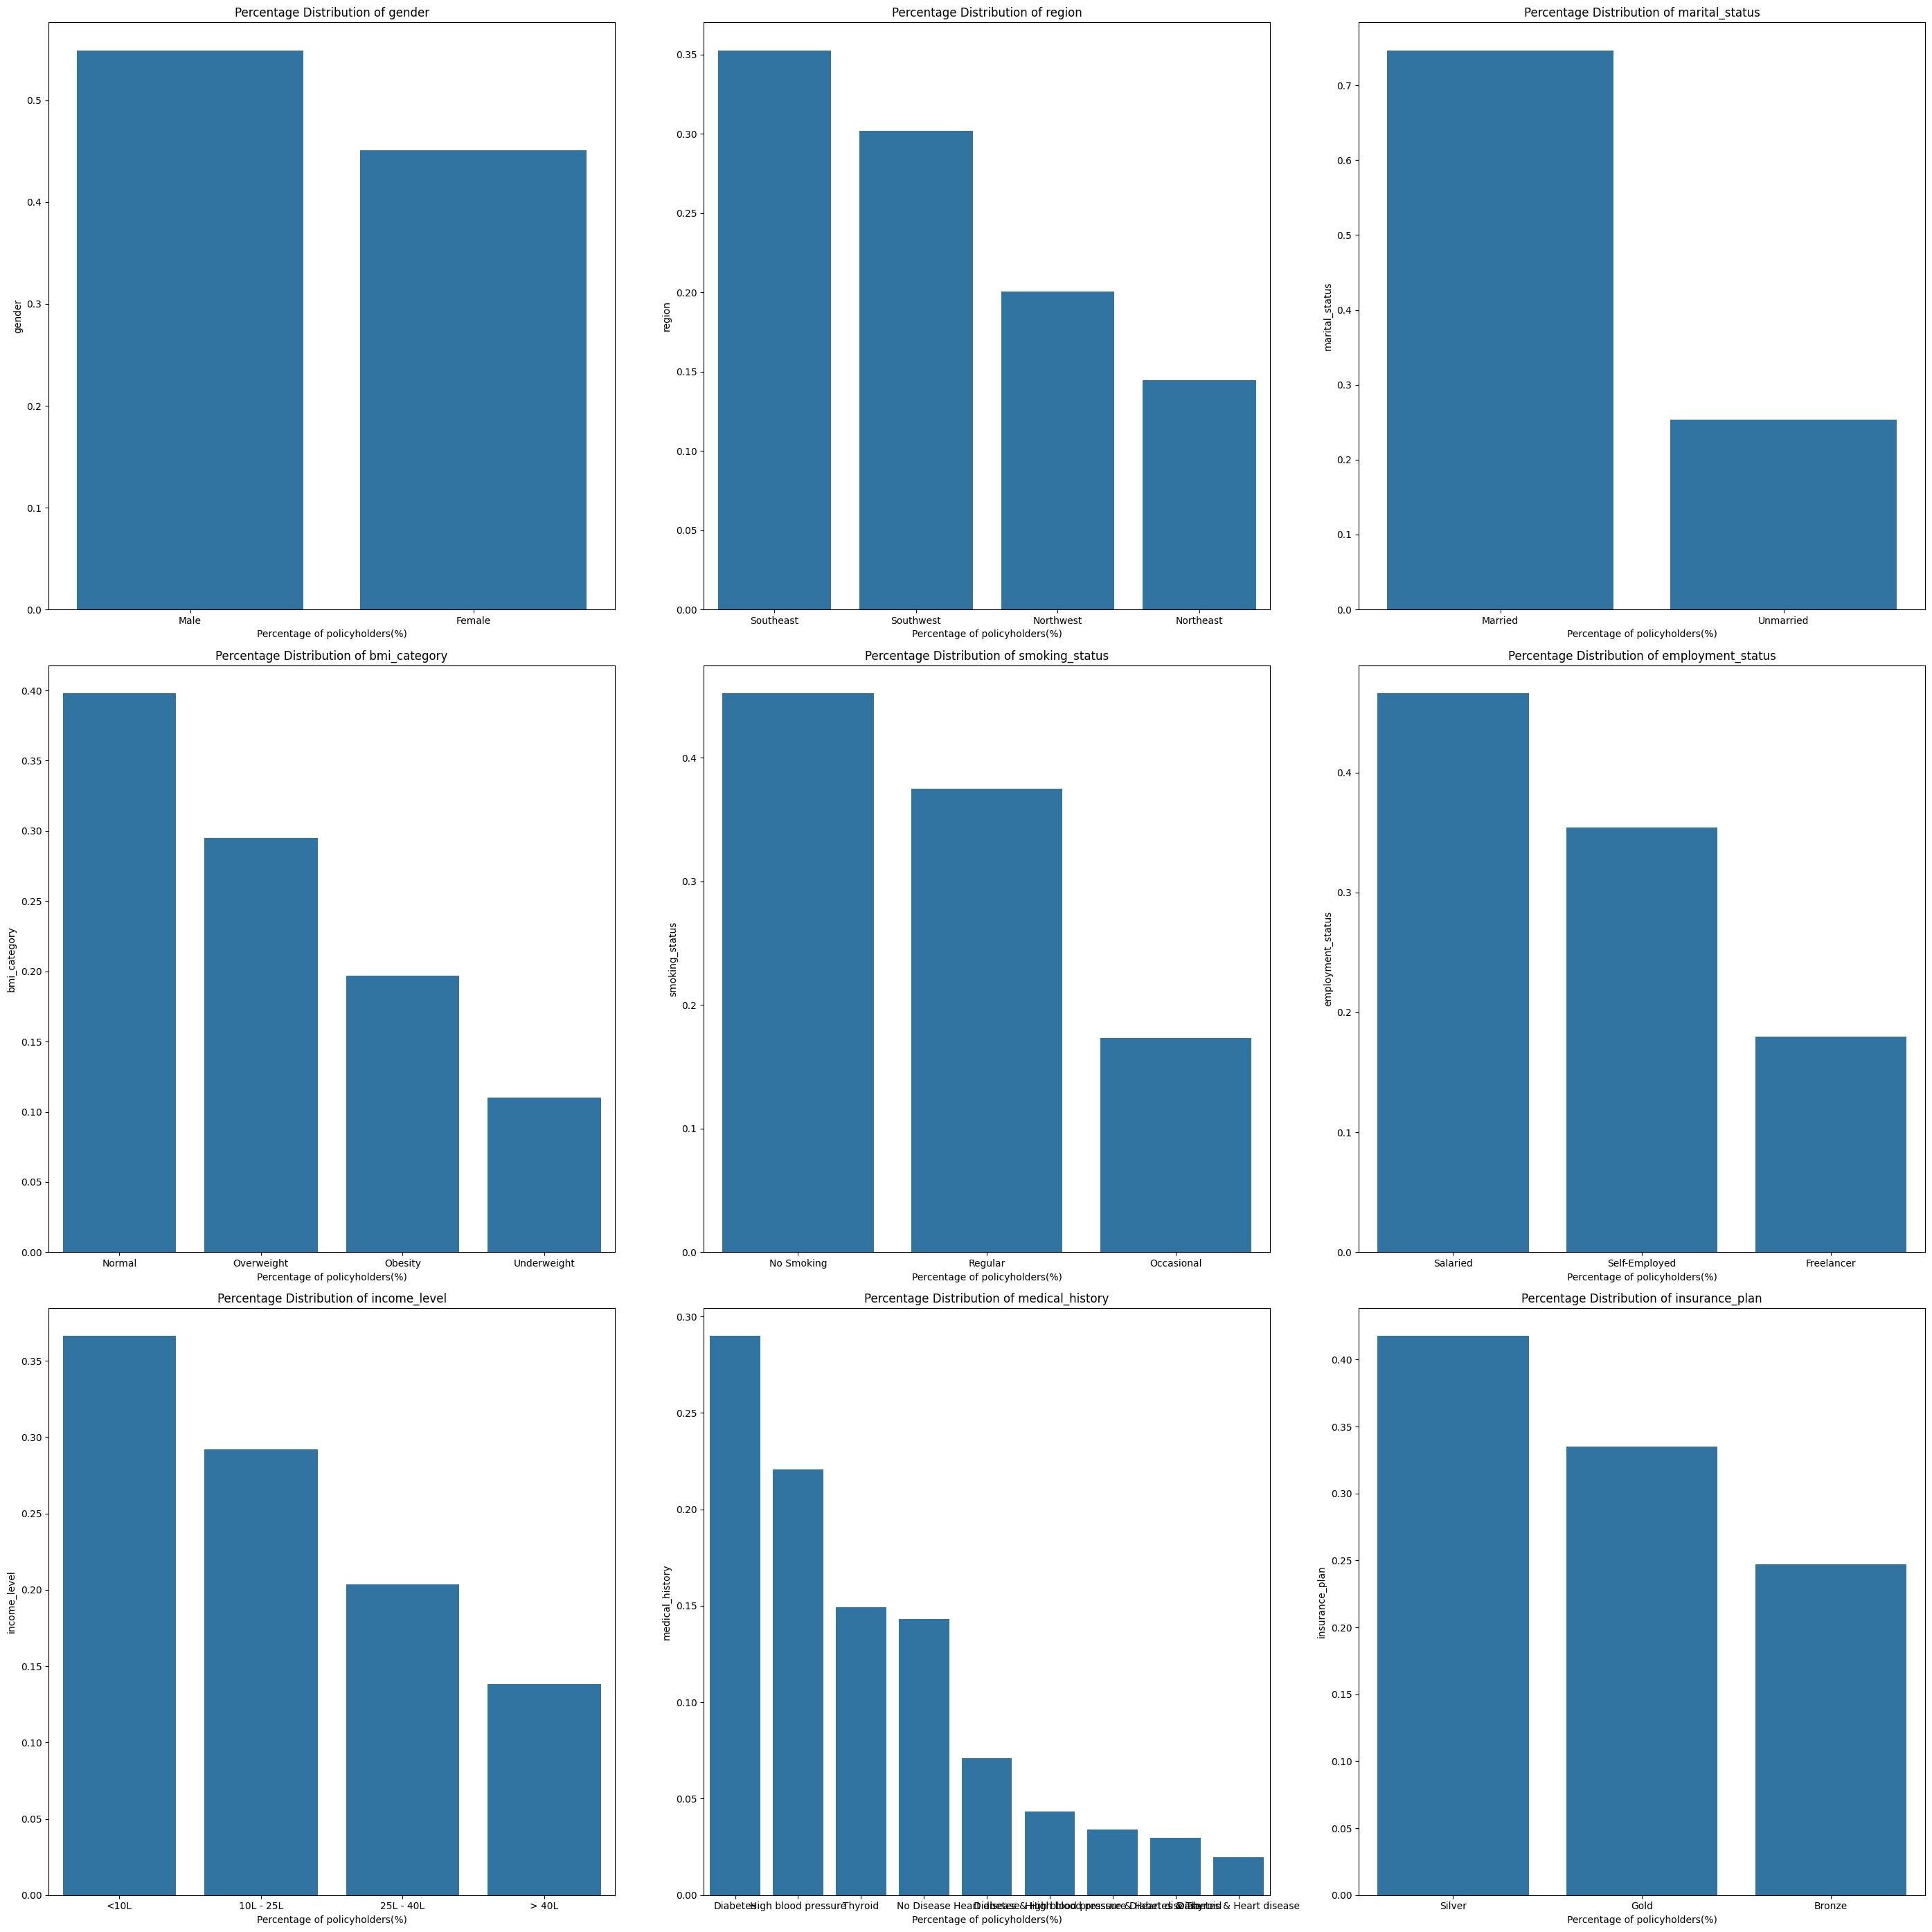

In [26]:
fig, axes=plt.subplots(3,3,figsize=(28,28))
axes=axes.flatten()
for ax, col in zip(axes, categorical_cols):
    category_counts=df2[col].value_counts(normalize=True)
    sns.barplot(x=category_counts.index,y=category_counts.values,ax=ax)
    ax.set_title(f'Percentage Distribution of {col}')
    ax.set_xlabel("Percentage of policyholders(%)")
    ax.set_ylabel(col)
plt.tight_layout()
plt.show()    

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          799  3554    4354
25L - 40L          301  2631    3142
<10L              6054   527    4341
> 40L              214  3287     618


<Axes: xlabel='income_level'>

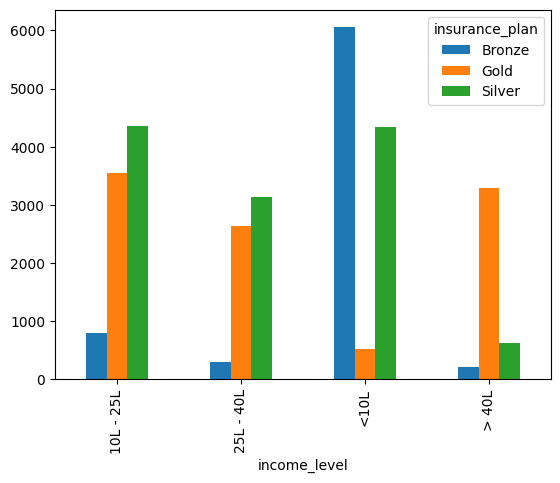

In [27]:
crosstab=pd.crosstab(df2['income_level'],df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar')

<Axes: xlabel='insurance_plan', ylabel='income_level'>

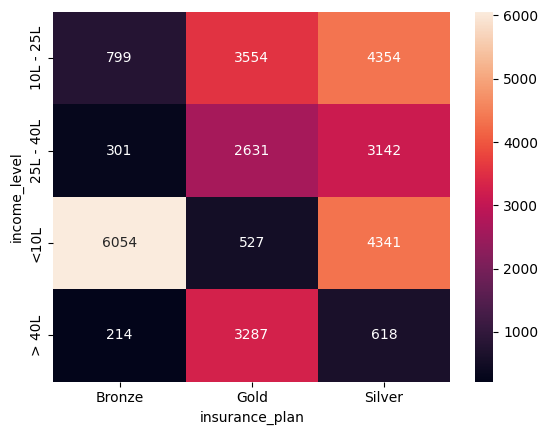

In [28]:
sns.heatmap(crosstab,annot=True,fmt='d')

# FEATURE ENGINEERING 

In [29]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [30]:
risk_scores={
    'diabetes':6,
    'heart disease':8,
    'high blood pressure':6,
    'thyroid':5,
    'no disease':0,
    'none':0
}

df2[['disease1','disease2']]= df2['medical_history'].str.split(' & ',expand =True).apply(lambda x:x.str.lower())
df2.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,None


In [31]:
df2['disease1'].fillna('none',inplace=True)
df2['disease2'].fillna('none',inplace=True)
df2['total_risk_score']=0

for disease in['disease1','disease2']:
    df2['total_risk_score']+=df2[disease].map(risk_scores)

max_score=df2['total_risk_score'].max()
min_score=df2['total_risk_score'].min()
df2['normalized_risk_score']=(df2['total_risk_score']-min_score)/(max_score-min_score)
df2.head()

/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_42745/308706082.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none',inplace=True)
/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_42745/308706082.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571


In [32]:
df2.sample(15)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
24690,58,Female,Northeast,Married,3,Obesity,No Smoking,Self-Employed,25L - 40L,38,Heart disease,Silver,26123,heart disease,none,8,0.571429
27749,55,Male,Northwest,Married,2,Obesity,Regular,Salaried,<10L,5,High blood pressure,Silver,25121,high blood pressure,none,6,0.428571
25665,60,Female,Southwest,Married,4,Normal,No Smoking,Self-Employed,<10L,9,High blood pressure,Bronze,10766,high blood pressure,none,6,0.428571
12065,48,Male,Northwest,Married,2,Obesity,No Smoking,Salaried,25L - 40L,35,High blood pressure,Gold,30997,high blood pressure,none,6,0.428571
13258,46,Male,Southwest,Married,3,Overweight,Regular,Self-Employed,> 40L,94,Heart disease,Gold,35954,heart disease,none,8,0.571429
10946,55,Female,Southeast,Married,4,Obesity,No Smoking,Self-Employed,25L - 40L,35,Thyroid,Silver,22808,thyroid,none,5,0.357143
15539,56,Male,Northeast,Married,4,Normal,Regular,Self-Employed,25L - 40L,28,Heart disease,Bronze,17920,heart disease,none,8,0.571429
20498,30,Male,Northeast,Unmarried,0,Overweight,No Smoking,Freelancer,<10L,7,Thyroid,Bronze,11588,thyroid,none,5,0.357143
23599,41,Male,Southeast,Married,4,Normal,Occasional,Salaried,10L - 25L,19,Thyroid,Silver,16919,thyroid,none,5,0.357143
23449,54,Male,Southeast,Unmarried,0,Normal,Regular,Salaried,<10L,1,Thyroid,Bronze,13712,thyroid,none,5,0.357143


In [33]:
df2.insurance_plan.unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [34]:
df2['insurance_plan']=df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2.insurance_plan.unique()


array([1, 2, 3])

In [35]:
df2.income_level.unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [36]:
df2['income_level'] = df2['income_level'].replace({
    '<10L': 1,
    '10L - 25L': 2,
    '25L - 40L': 3,
    '> 40L': 4
})


/var/folders/r_/zhk06phn5rg0kd9cv4qb47140000gn/T/ipykernel_42745/3591113900.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2['income_level'] = df2['income_level'].replace({


In [37]:
nominal_cols = [
    'gender',
    'region',
    'marital_status',
    'bmi_category',
    'smoking_status',
    'employment_status',
]

df3 = pd.get_dummies(df2,columns=nominal_cols,drop_first=True,dtype=int)

df4=df3.drop(['medical_history','disease1','disease2','total_risk_score'],axis=1)
df4.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


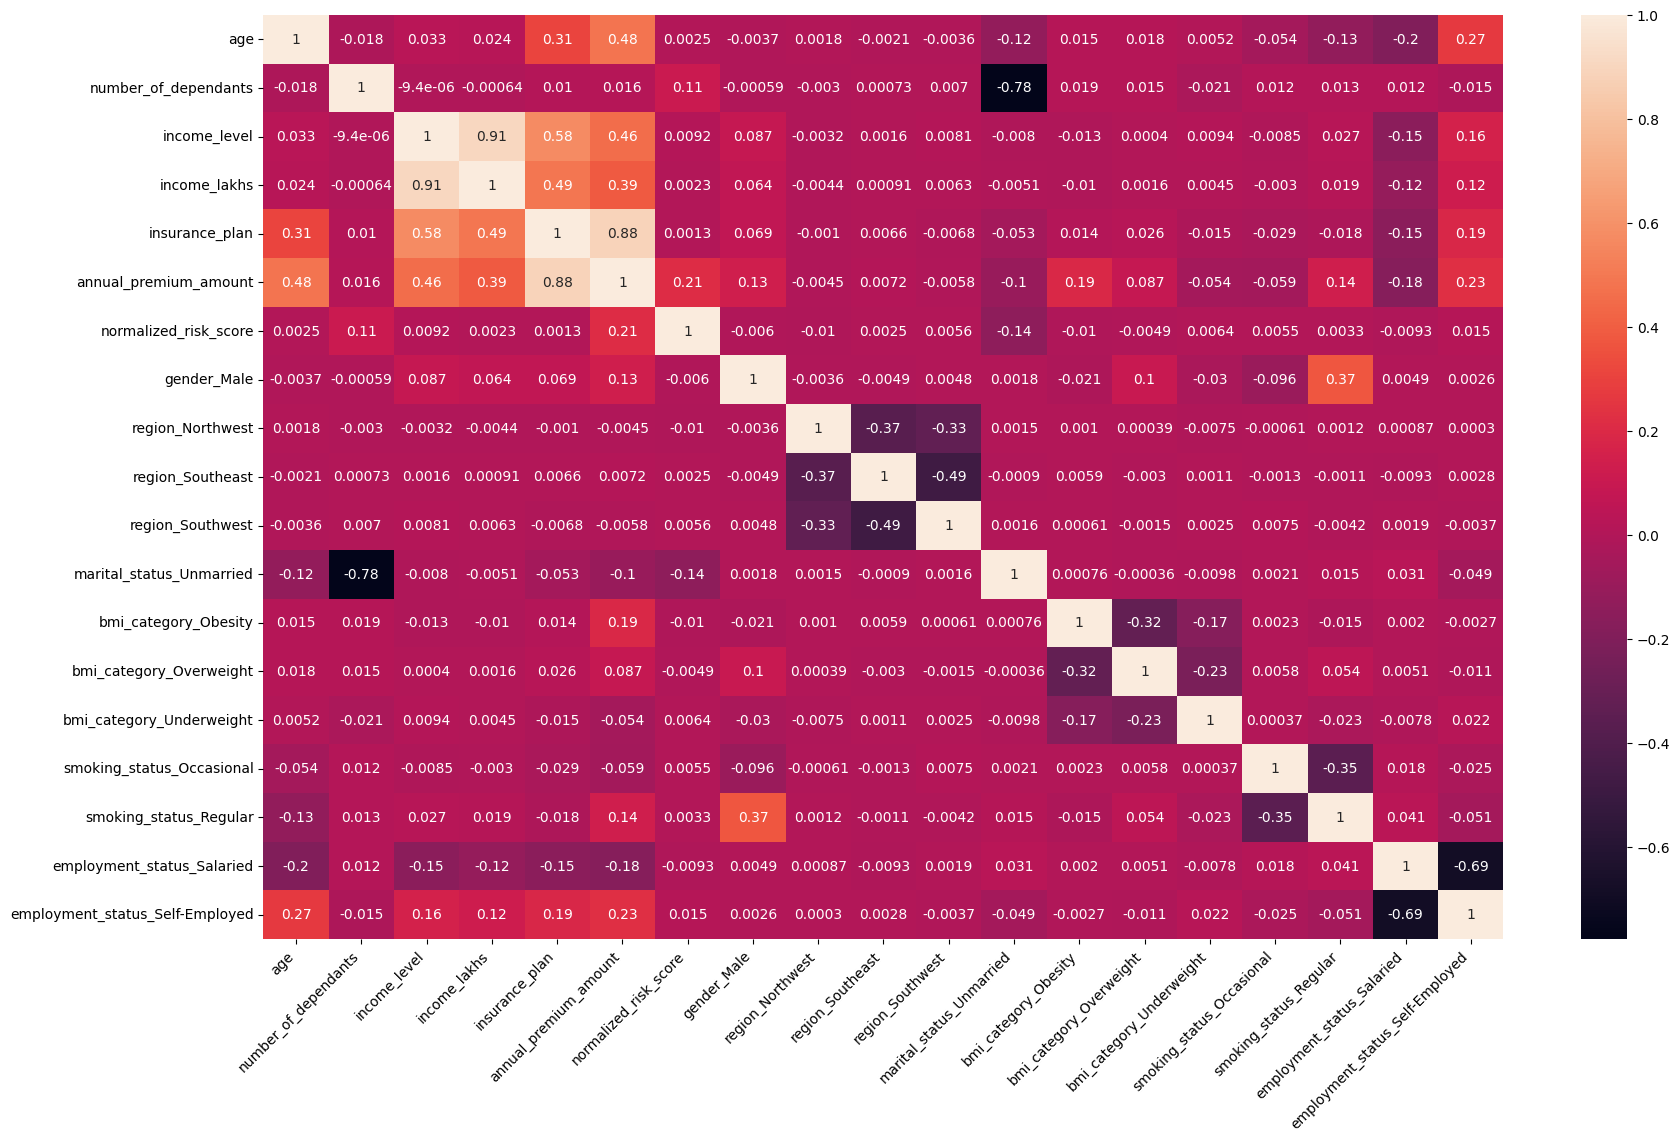

In [38]:
cm=df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm,annot=True)
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0)
plt.show()

In [39]:
df4.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0


In [40]:
print(df4.dtypes)


age                                  int64
number_of_dependants                 int64
income_level                         int64
income_lakhs                         int64
insurance_plan                       int64
annual_premium_amount                int64
normalized_risk_score              float64
gender_Male                          int64
region_Northwest                     int64
region_Southeast                     int64
region_Southwest                     int64
marital_status_Unmarried             int64
bmi_category_Obesity                 int64
bmi_category_Overweight              int64
bmi_category_Underweight             int64
smoking_status_Occasional            int64
smoking_status_Regular               int64
employment_status_Salaried           int64
employment_status_Self-Employed      int64
dtype: object


In [41]:
df4 = df4.copy()
df4 = df4.apply(pd.to_numeric, errors='coerce')

In [42]:
X = df4.drop('annual_premium_amount', axis='columns')
y = df4['annual_premium_amount']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs','insurance_plan']

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [43]:
def calculate_vif(data):
    vif_df=pd.DataFrame()
    vif_df['columns']=data.columns
    vif_df['VIF']=[variance_inflation_factor(data.values,i)for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,columns,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,normalized_risk_score,3.810619
6,gender_Male,2.599098
7,region_Northwest,2.123965
8,region_Southeast,2.980842
9,region_Southwest,2.710097


In [44]:
calculate_vif(X.drop('income_level',axis='columns'))

,columns,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,normalized_risk_score,3.808345
5,gender_Male,2.591439
6,region_Northwest,2.123277
7,region_Southeast,2.979899
8,region_Southwest,2.708641
9,marital_status_Unmarried,2.345757


In [45]:
X_reduced=X.drop('income_level',axis='columns')
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


# MODEL TRAINING 

In [46]:
X_train, X_test, y_train , y_test=train_test_split(X_reduced,y,test_size=0.3,random_state=10)

In [47]:
model_LR=LinearRegression()
model_LR.fit(X_train,y_train)
test_score = model_LR.score(X_test,y_test)
train_score = model_LR.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9534163989489616
Test Score :0.9538448451629948


In [48]:
y_pred =model_LR.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)

print("Linear Regression ==> :",mse_lr,"\nrmse:",rmse_lr)

Linear Regression ==> : 2183844.360312456 
rmse: 1477.7835972538253


In [49]:
X_test.head(1)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
19713,0.652174,0.0,0.262626,1.0,0.428571,0,0,0,1,1,0,0,0,0,0,0,1


In [50]:
model_LR.intercept_

np.float64(5935.981289344592)

In [51]:
model_LR.coef_ #how much they contribute to the model

array([ 7016.2393283 , -1311.76470171,  -708.19336921, 14835.98820801,
        6053.6241234 ,    37.55826883,   -55.25087215,   -19.62254288,
         -22.28967559,  -700.32019985,  3926.8127061 ,  1979.45604663,
         612.86623617,   837.3951011 ,  2800.66184334,   -45.49136706,
         243.07842087])

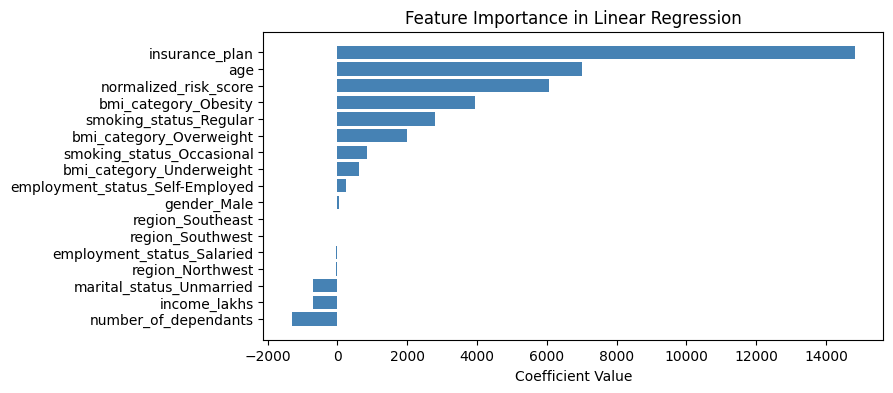

In [52]:
feature_importances = model_LR.coef_

coef_df= pd.DataFrame(feature_importances, index= X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=True)
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel("Coefficient Value")
plt.title('Feature Importance in Linear Regression')
plt.show()

In [53]:
model_rg=Ridge()
model_rg.fit(X_train,y_train)
test_score = model_rg.score(X_test,y_test)
train_score = model_rg.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9534162332209687
Test Score :0.9538456995663841


In [54]:
from xgboost import XGBRegressor
model_xg=XGBRegressor()
model_xg.fit(X_train,y_train)
test_score = model_xg.score(X_test,y_test)
train_score = model_xg.score(X_train,y_train)
print(f'Train Score :{train_score}')
print(f'Test Score :{test_score}')

Train Score :0.9986370801925659
Test Score :0.9979538321495056


In [55]:
y_pred =model_xg.predict(X_test)
mse_lr=mean_squared_error(y_test,y_pred)
rmse_lr=np.sqrt(mse_lr)

print("XGBoost Regression ==> :",mse_lr,"\nrmse:",rmse_lr)

XGBoost Regression ==> : 96814.2109375 
rmse: 311.14982072548264


In [56]:
param_grid={
    'n_estimators':[20,40,50],
    'learning_rate' : [0.01,0,.1,0.2],
    'max_depth': [3,4,5]
}

random_search= RandomizedSearchCV(model_xg,param_grid,n_iter=10,cv=3,scoring='r2',random_state=10)
random_search.fit(X_train,y_train)
random_search.best_score_

np.float64(0.9979600111643473)

In [57]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.2}

In [58]:
best_model = random_search.best_estimator_

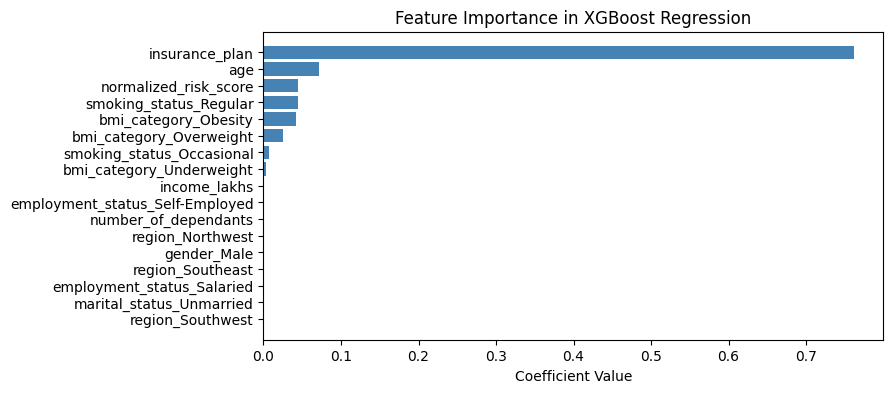

In [59]:
feature_importances = best_model.feature_importances_

coef_df= pd.DataFrame(feature_importances, index= X_test.columns,columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=True)
plt.figure(figsize=(8,4))
plt.barh(coef_df.index, coef_df['Coefficients'], color = 'steelblue')
plt.xlabel("Coefficient Value")
plt.title('Feature Importance in XGBoost Regression')
plt.show()

### ERROR ANALYSIS

In [60]:
y_pred=best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals*100/y_test


results_df=pd.DataFrame({
    'actual':y_test,
    'predicted':y_pred,
    'diff':residuals,
    'diff_pct': residuals_pct
})

results_df

,actual,predicted,diff,diff_pct
19713,26895,26597.738281,-297.261719,-1.105268
14750,22734,23061.767578,327.767578,1.441751
19932,21198,21493.767578,295.767578,1.395262
29643,9100,9176.055664,76.055664,0.835777
17076,26434,26597.738281,163.738281,0.619423
...,...,...,...,...
3387,9291,9176.055664,-114.944336,-1.237158
7858,18261,18072.097656,-188.902344,-1.034458
9744,12419,12141.349609,-277.650391,-2.235690
4849,29735,29597.126953,-137.873047,-0.463673


<Axes: xlabel='diff_pct', ylabel='Count'>

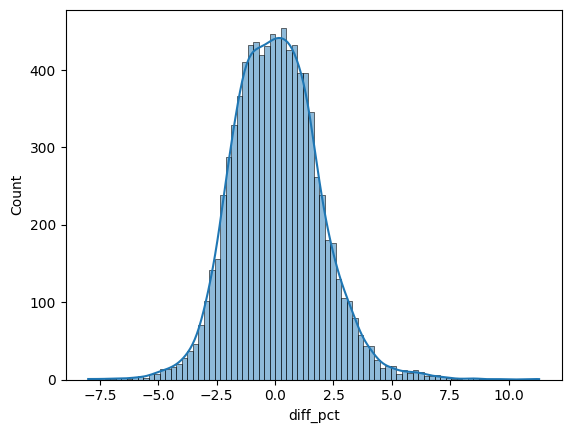

In [61]:
sns.histplot(results_df['diff_pct'],kde=True)

In [62]:
extreme_error_threshold=10

extreme_results_df=results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(3, 4)

In [63]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.03353079244439477

In [64]:
results_df[np.abs(results_df.diff_pct)>50].sort_values(by='diff_pct',ascending=False)


,actual,predicted,diff,diff_pct


In [65]:
X_test.index

Index([19713, 14750, 19932, 29643, 17076, 20314, 24893, 26722, 25844, 10731,
       ...
       10637,  1224, 17046, 19228,  9275,  3387,  7858,  9744,  4849,  8986],
      dtype='int64', length=8947)

In [66]:
extreme_results_df.index

Index([7547, 12189, 6517], dtype='int64')

In [67]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
7547,0.347826,0.2,0.080808,0.0,0.0,1,0,1,0,1,0,0,0,0,0,1,0
12189,0.043478,0.6,0.060606,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1,0
6517,0.304348,0.8,0.030303,0.0,0.0,0,0,0,1,0,0,0,0,0,0,1,0


In [68]:
print(X_test.columns.tolist())


['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'normalized_risk_score', 'gender_Male', 'region_Northwest', 'region_Southeast', 'region_Southwest', 'marital_status_Unmarried', 'bmi_category_Obesity', 'bmi_category_Overweight', 'bmi_category_Underweight', 'smoking_status_Occasional', 'smoking_status_Regular', 'employment_status_Salaried', 'employment_status_Self-Employed']


Skipping missing feature: income_level


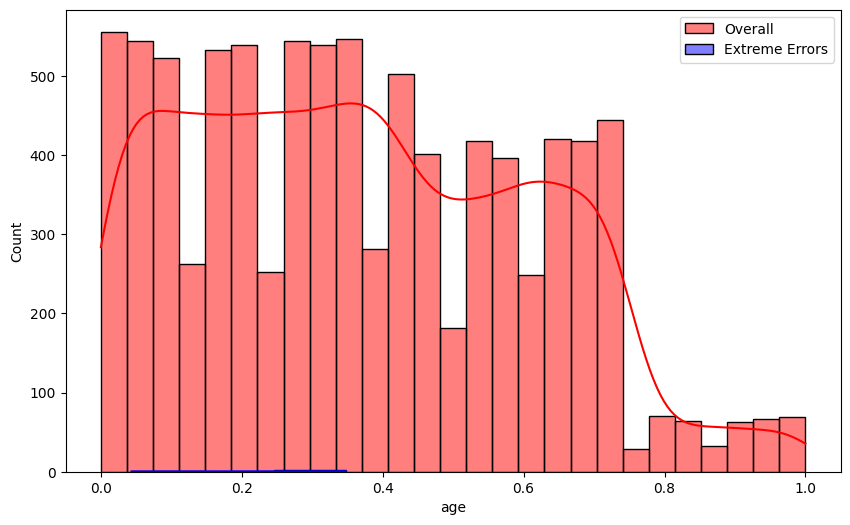

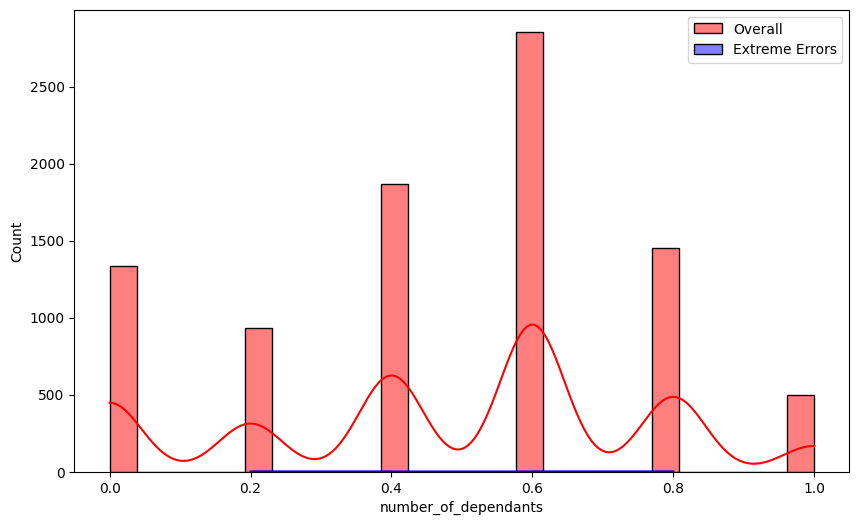

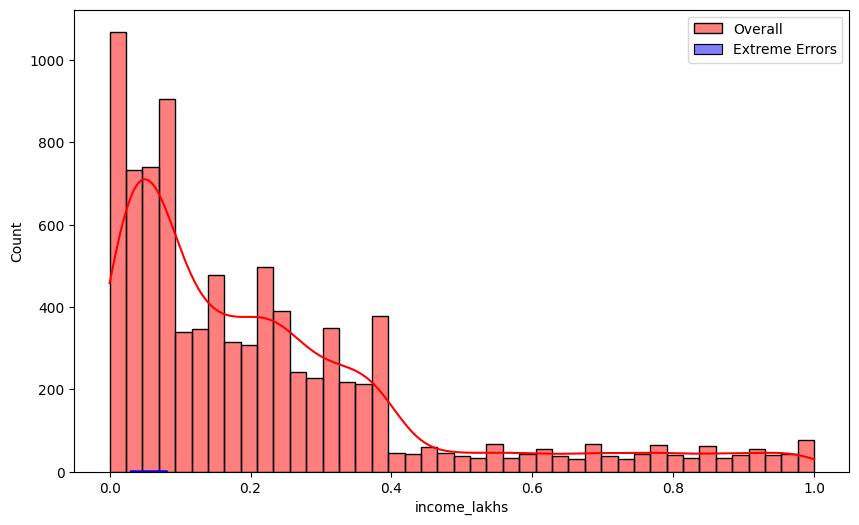

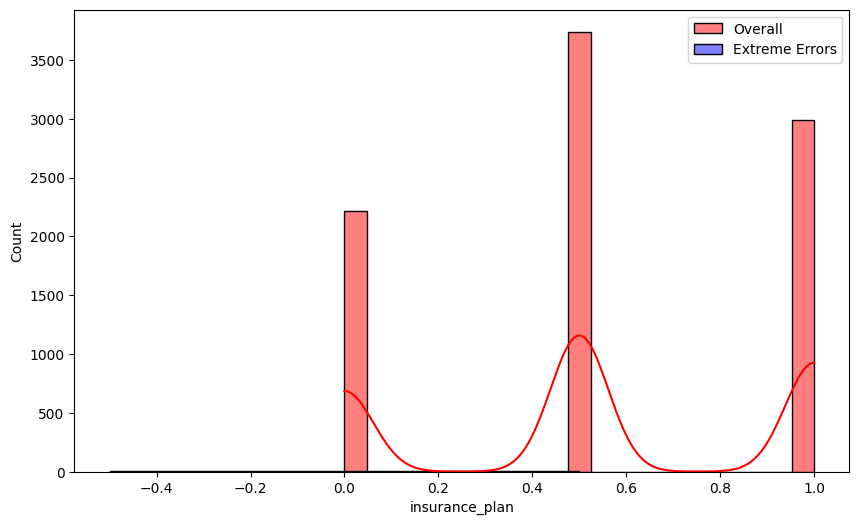

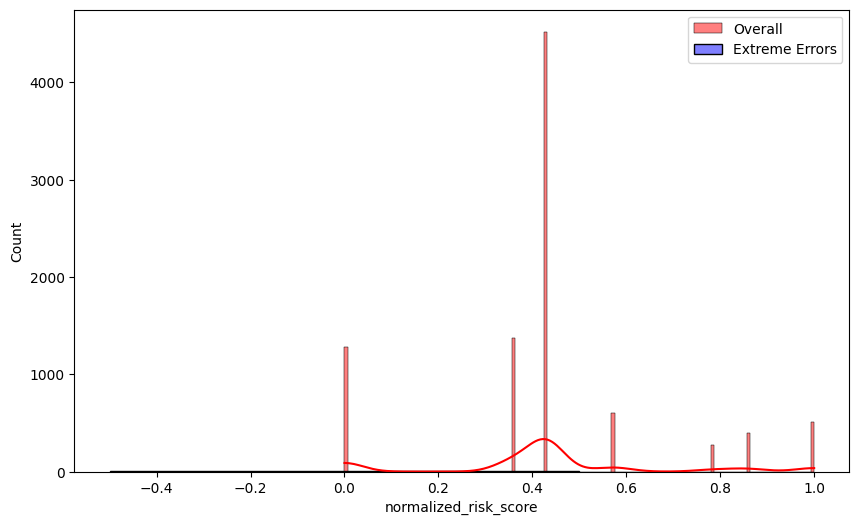

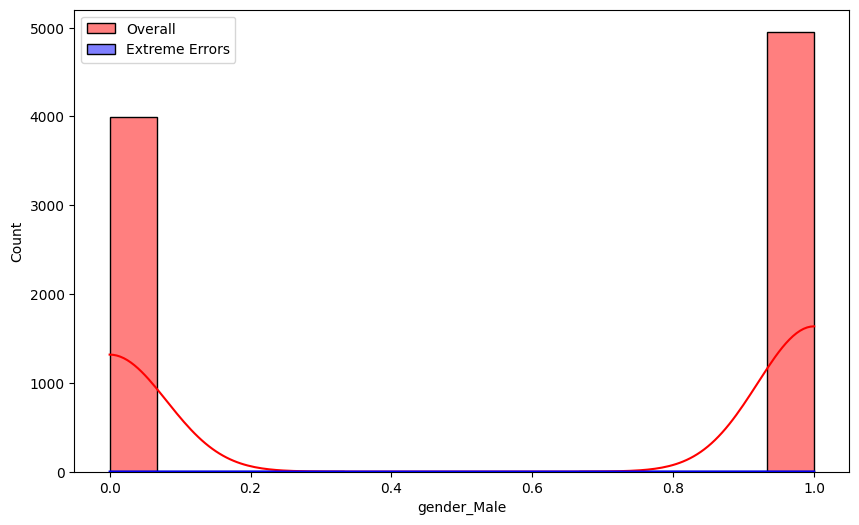

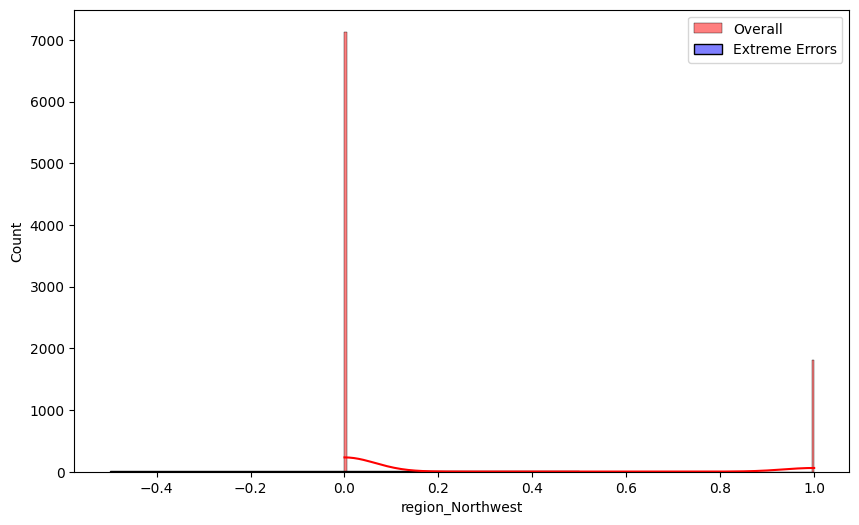

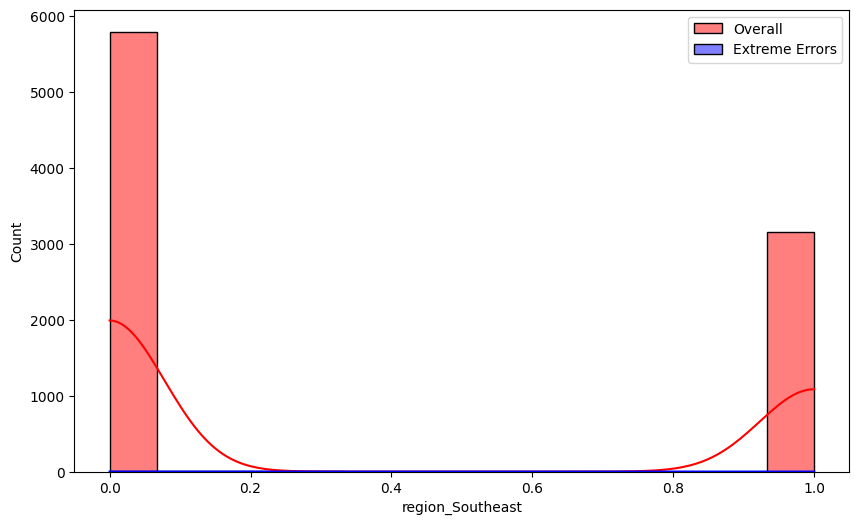

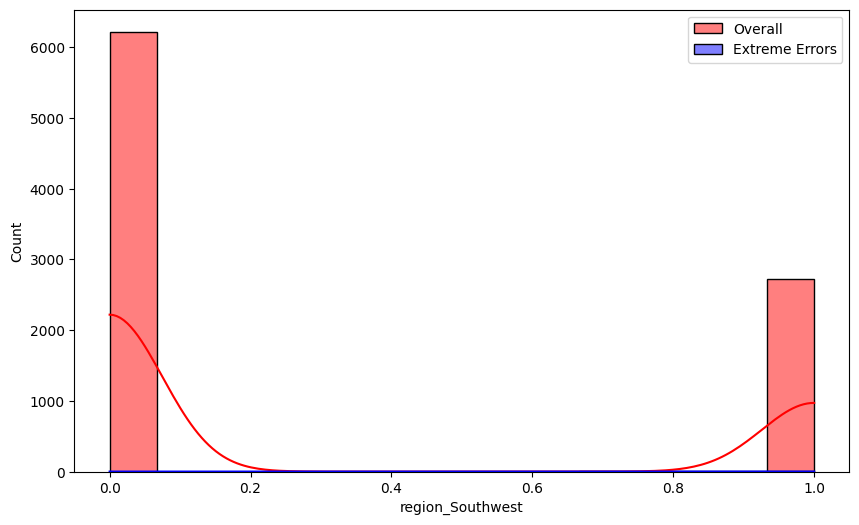

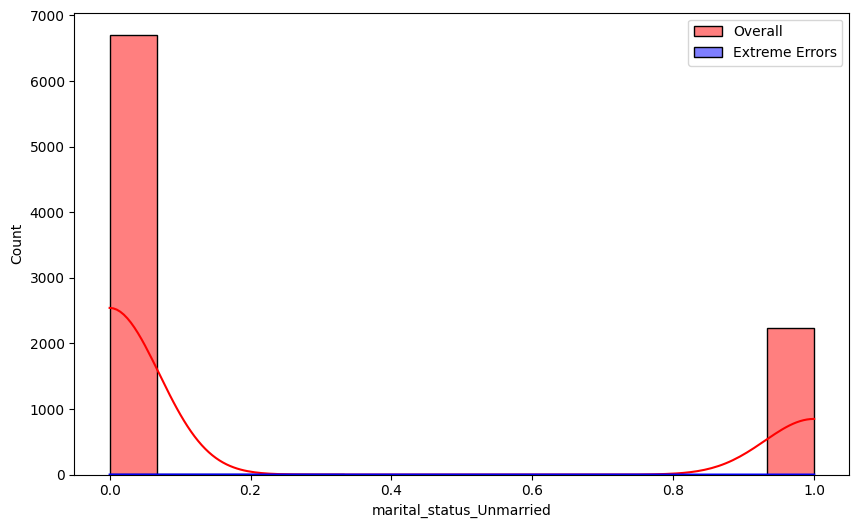

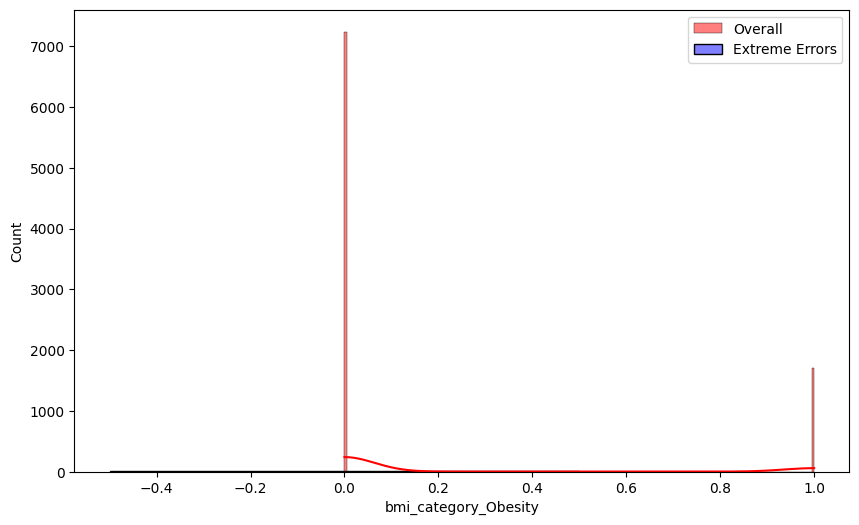

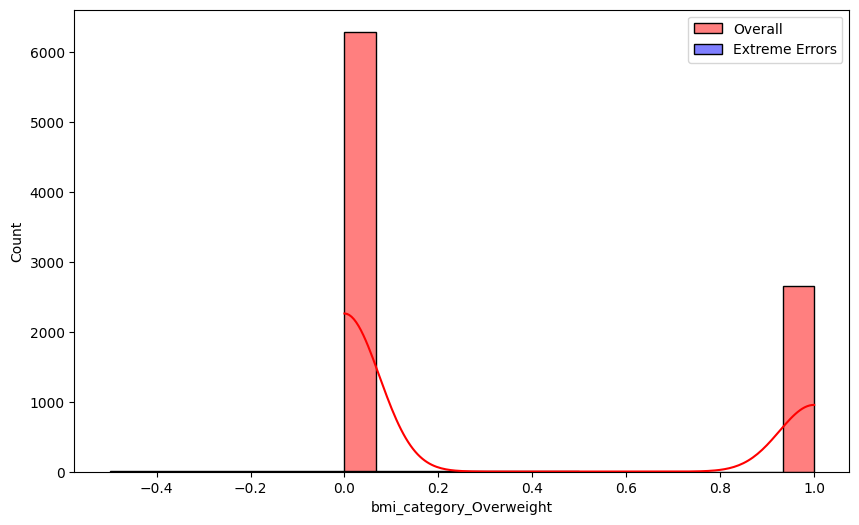

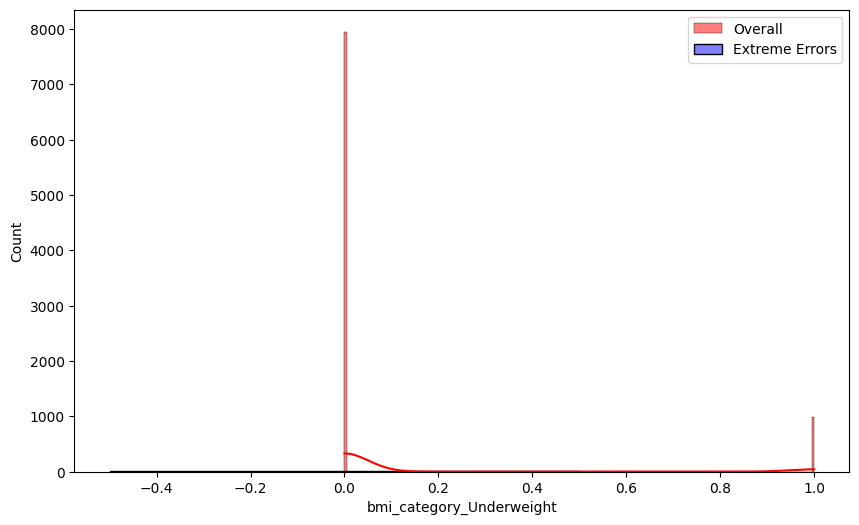

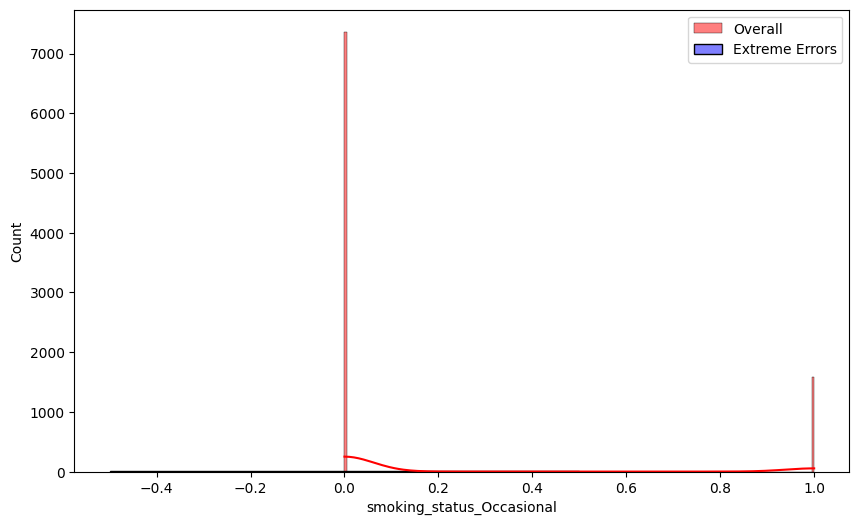

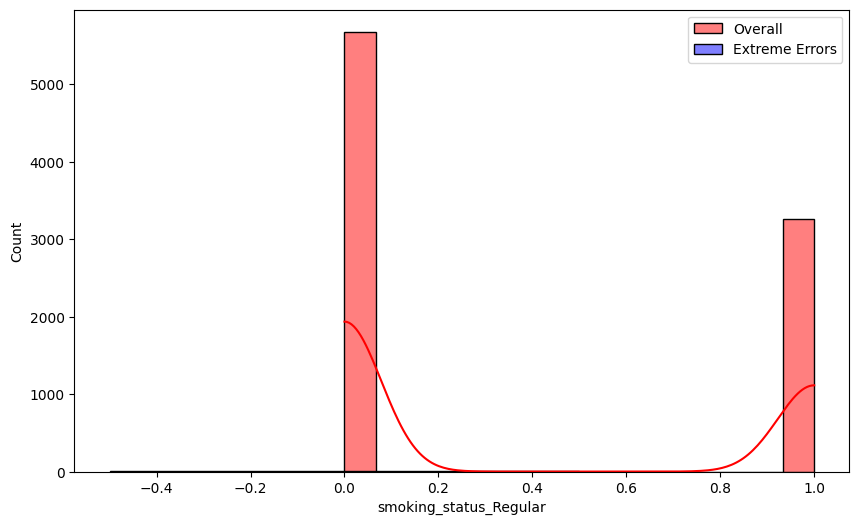

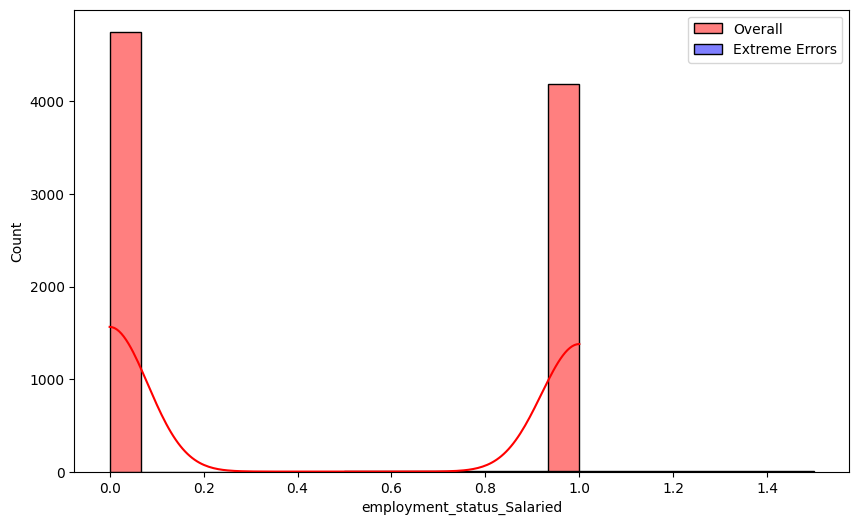

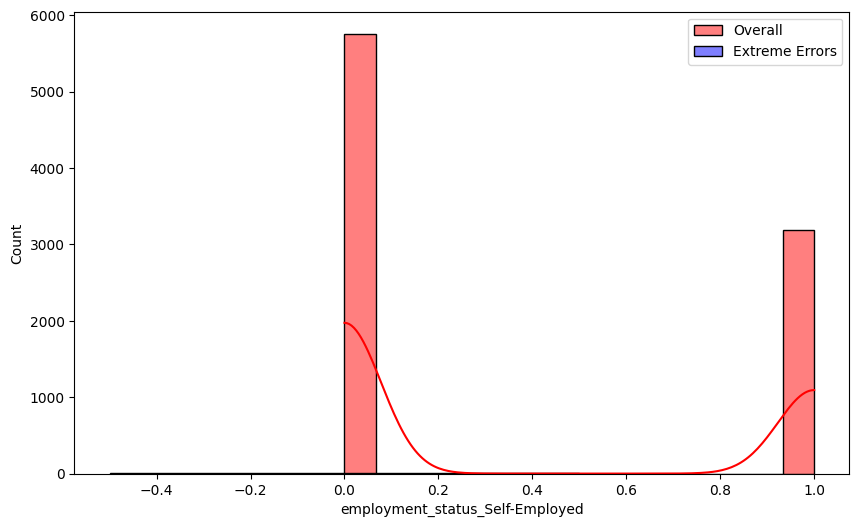

In [69]:
for feature in X.columns:
    if feature in X_test.columns:
        plt.figure(figsize=(10,6))
        sns.histplot(X_test[feature], color='red', label='Overall', kde=True)
        sns.histplot(extreme_errors_df[feature], color='blue', alpha=0.5, label='Extreme Errors', kde=True)
        plt.legend()
    else:
        print(f"Skipping missing feature: {feature}")


In [70]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [71]:
extreme_errors_df['income_level']= -1

<Axes: xlabel='age', ylabel='Count'>

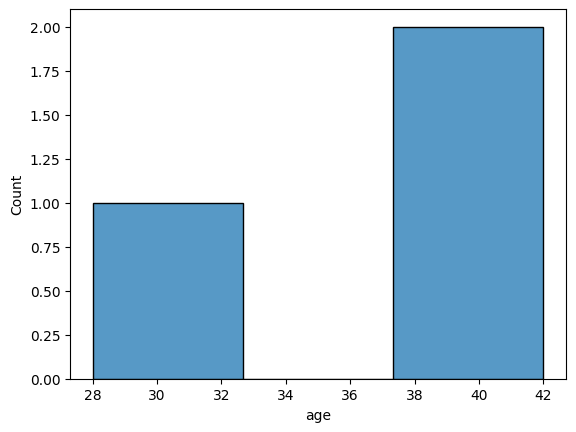

In [72]:
df_reversed=pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])

sns.histplot(df_reversed['age'])

# MODEL SEGMENTATION